In [1]:
import sys

sys.path.append("../kalmannet")
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import matplotlib
%matplotlib widget

In [2]:
font = {'size'   : 12}

matplotlib.rc('font', **font)

In [4]:
pipeline = torch.load("..\models\pipeline_KNet_fingflexion_06_13_22__08_52_01")

Running on the CPU


In [5]:
X_test = scio.loadmat("../data/finger_flexion/X_test.mat")
Y_test = scio.loadmat("../data/finger_flexion/Y_test.mat")
# X_train = scio.loadmat("../data/finger_flexion/X_train.mat")
# Y_train = scio.loadmat("../data/finger_flexion/Y_train.mat")
# X_val = scio.loadmat("../data/finger_flexion/X_val.mat")
# Y_val = scio.loadmat("../data/finger_flexion/Y_val.mat")
X_test = torch.tensor(X_test["X_test"]).t().float()
Y_test = torch.tensor(Y_test["Y_test"]).t().float()
# X_train = torch.tensor(X_train["X_train"]).t().float()
# Y_train = torch.tensor(Y_train["Y_train"]).t().float()
# X_val = torch.tensor(X_val["X_val"]).t().float()
# Y_val = torch.tensor(Y_val["Y_val"]).t().float()
kf_pred = scio.loadmat("../data/finger_flexion/kf_test_result.mat")["pred_X"]


Text(0.5, 0, 'Epoch')

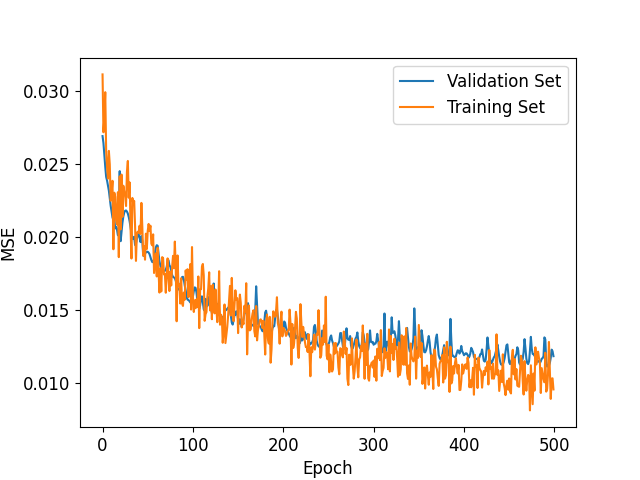

In [6]:
# Training and Validation MSE across training
plt.figure()
plt.plot(np.power(10, pipeline.MSE_cv_dB_epoch.cpu()/10))
plt.plot(np.power(10, pipeline.MSE_train_dB_epoch.cpu()/10))
plt.legend(["Validation Set", "Training Set"])
plt.ylabel("MSE")
plt.xlabel("Epoch")

In [7]:
# Show reconstruction of test
x_out_test = torch.empty(pipeline.ssModel.m, X_test.shape[1])
KGain_test = torch.empty(pipeline.ssModel.m, pipeline.ssModel.n, X_test.shape[1])
for t in range(0, X_test.shape[1]):
    KGain_test[:,:,t] = pipeline.model.KGain
    x_out_test[:, t] = pipeline.model(Y_test[:, t])

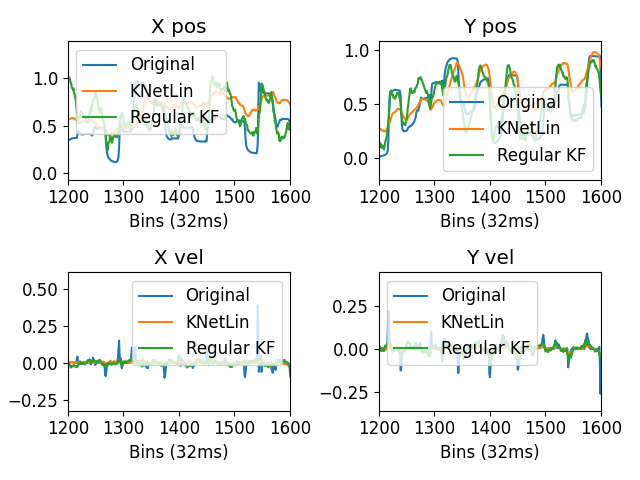

In [13]:
fig = plt.figure()
titles = ["X pos", "Y pos", "X vel","Y vel"]
for i in range(4):
    plt.subplot(221+i)
    plt.plot(X_test[i,:].detach().cpu().numpy())
    plt.plot(x_out_test[i,:].detach().cpu().numpy())
    plt.plot(kf_pred[i,:])
    # if i ==3:
    plt.legend(["Original","KNetLin", "Regular KF"])
    plt.xlabel("Bins (32ms)")
    plt.xlim(1200, 1600)
    plt.title(titles[i])
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"


In [10]:
corr = np.zeros(4)
for i in range(4):
    corr[i] = np.corrcoef(x_out_test[i, :].detach().cpu(), X_test[i, :].cpu())[0, 1]
mse_x = np.square(np.subtract(x_out_test.detach().cpu(), X_test.cpu())).mean(1)

In [11]:
corr, mse_x

(array([0.56618869, 0.6467244 , 0.2526909 , 0.47607831]),
 tensor([0.0537, 0.0361, 0.0014, 0.0013], device='cpu'))

In [15]:
np.mean(corr)

0.4854205738503563

## Kalman Gain evolution

In [12]:
Kgain_kf = scio.loadmat("data/kgain_kf.mat")
Kgain_kf = torch.tensor(Kgain_kf["KGain_kf"]).float()

<IPython.core.display.Javascript object>


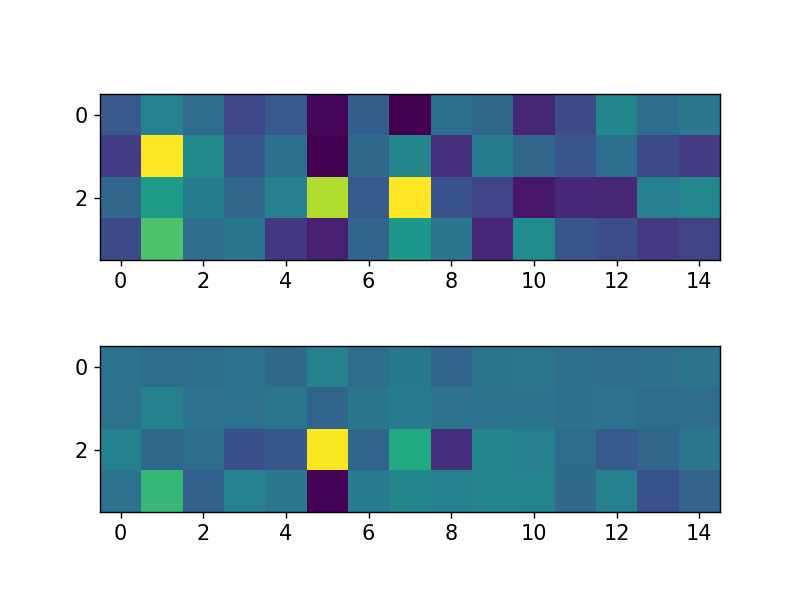

In [13]:
from matplotlib.animation import FuncAnimation
fig, (ax1,ax2) = plt.subplots(2,1)
im1 = ax1.imshow(KGain_test[:,:,1].detach().cpu())
im2 = ax2.imshow(Kgain_kf[:,:,0].cpu())
def animate(frame_num):
    im1.set_data(KGain_test[:,:,frame_num+1].detach().cpu())
    im2.set_data(Kgain_kf[:,:,frame_num].cpu())
    return im1,im2
anim = FuncAnimation(fig, animate, frames=4711, interval=50, repeat=False)
# anim.save('figures/animation.gif', writer='imagemagick', fps=30)
plt.show()

## Data export

In [17]:
np.save("data/kgain_knet.npy",KGain_test.detach().cpu())
np.save("data/kgain_kf.npy", Kgain_kf.cpu())
np.save("data/neural_data_input.npy",Y_test.cpu())
np.save("data/state_ground_truth.npy", X_test.cpu())
np.save("data/predictions_knet.npy", x_out_test.detach().cpu())